In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
data = np.load('./local_magnitude.npz')

for key in data.files:
    print(f"{key}: {data[key]}")

# targetL Ml
Ml   = data["Y"]
# features
amp  = data["X"][:, 0]   # peak displacement amplitude
dist = data["X"][:, 1]   # epicentral distance

X: [[3.4520824e+07 5.5700001e+01 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [7.8583592e+07 2.7850000e+01 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.9069914e+08 8.8100004e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [6.2442496e+07 6.0610001e+01 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.2059925e+08 2.9660000e+01 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [7.6300072e+07 8.0250000e+01 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
Y: [0.89 0.89 0.89 ... 1.19 1.19 1.19]


### <b>a. Histograms</b>

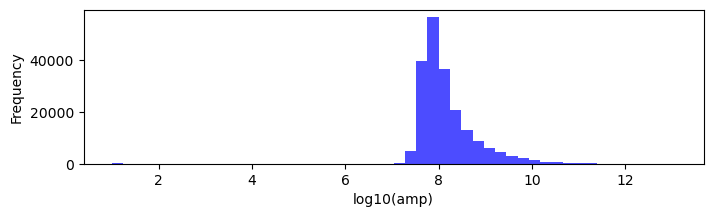

In [3]:
log_amp = np.log10(amp)

plt.figure(figsize=(8, 2))
plt.hist(log_amp, bins=50, color='blue', alpha=0.7)
plt.xlabel('log10(amp)')
plt.ylabel('Frequency')
plt.show()

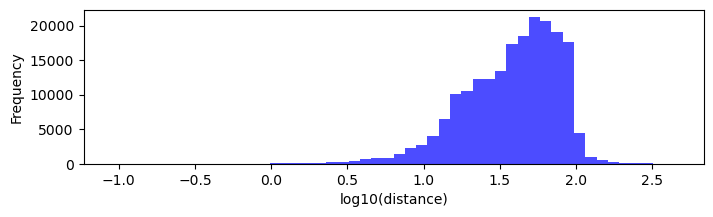

In [4]:
log_dist = np.log10(dist)

plt.figure(figsize=(8, 2))
plt.hist(log_dist, bins=50, color='blue', alpha=0.7)
plt.xlabel('log10(distance)')
plt.ylabel('Frequency')
plt.show()

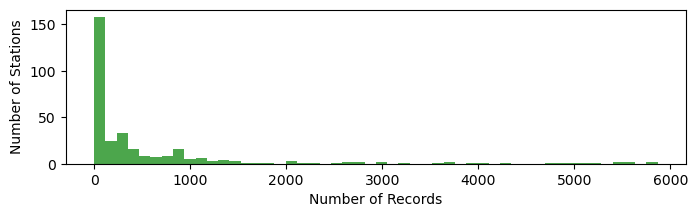

In [5]:
# number of records for each station
num_records = data["X"][:, 2:].sum(axis=0)  

plt.figure(figsize=(8, 2))
plt.hist(num_records, bins=50, color='green', alpha=0.7)
plt.xlabel('Number of Records')
plt.ylabel('Number of Stations')
plt.show()

### <b>b. Scaling</b>

In [7]:
max_log_amp = np.max(log_amp)
min_log_amp = np.min(log_amp)

max_log_dist = np.max(log_dist)
min_log_dist = np.min(log_dist)

# normalize
norm_log_amp = (log_amp - min_log_amp) / (max_log_amp - min_log_amp)
norm_log_dist = (log_dist - min_log_dist) / (max_log_dist - min_log_dist)

### <b>c. scikit-learn Linear Fit</b>

In [8]:
X1 = np.column_stack((norm_log_amp, norm_log_dist, data["X"][:, 2:]))

# Perform linear regression
model1 = LinearRegression()
model1.fit(X1, Ml)
# Predict the target values
predicted_Ml1 = model1.predict(X1)

# Calculate RMSE
rmse1 = np.sqrt(mean_squared_error(Ml, predicted_Ml1))
print("RMSE (all features included):", rmse1)

# only first two features
X2 = np.column_stack((norm_log_amp, norm_log_dist))
model2 = LinearRegression()
model2.fit(X2, Ml)
predicted_Ml2 = model2.predict(X2)
rmse2 = np.sqrt(mean_squared_error(Ml, predicted_Ml2))
print("RMSE (only log_amp and log_dist, normalized):", rmse2)

RMSE (all features included): 0.36825472092818023
RMSE (only log_amp and log_dist, normalized): 0.4161532276169181


### <b>d. Two-layer NN</b>

In [ ]:
n_RealFeatures   = 2
n_HiddenFeatures = 32
n_Output         = 1

In [10]:
def initialize_weights(n_RealFeatures, n_HiddenFeatures, n_Output, mu=0, sigma=0.01, seed=42, print_shapes=True):
    np.random.seed(seed)
    W1 = np.random.normal(mu, sigma, (n_RealFeatures, n_HiddenFeatures))
    W2 = np.random.normal(mu, sigma, (n_HiddenFeatures, n_Output))
    b1 = np.zeros((1, n_HiddenFeatures))
    b2 = np.zeros((1, n_Output))
    num_params = W1.size + W2.size + b1.size + b2.size
    if print_shapes:
        print("shape of W1:", W1.shape)
        print("shape of W2:", W2.shape)
        print("shape of b1:", b1.shape)
        print("shape of b2:", b2.shape)
        print("Number of parameters in the neural network:", num_params)
    return W1, W2, b1, b2

# Example usage
W1, W2, b1, b2 = initialize_weights(n_RealFeatures, n_HiddenFeatures, n_Output, print_shapes=True)

shape of W1: (2, 32)
shape of W2: (32, 1)
shape of b1: (1, 32)
shape of b2: (1, 1)
Number of parameters in the neural network: 129


In [11]:
# activation func

def ReLU(x):
    return np.maximum(0, x)

# Derivative of ReLU
def relu_derivative(x):
    return np.array(x > 0).astype(float)

In [12]:
def Forward(X, params, print_shapes=False):
    # unpack
    W1, W2, b1, b2 = params
    
    f = np.dot(X, W1) + b1      # hidden layer pre-activation
    Z = ReLU(f)                 # activation
    y_hat = np.dot(Z, W2) + b2 
    if print_shapes:            
        print("shape of f:", f.shape)
        print("shape of Z:", Z.shape)    
        print("shape of y_hat:", y_hat.shape)
    return y_hat, Z, f

In [13]:
y_hat, Z, f = Forward(X2, (W1, W2, b1, b2), print_shapes=True)
relu_derivative(f)

shape of f: (200000, 32)
shape of Z: (200000, 32)
shape of y_hat: (200000, 1)


array([[1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       ...,
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.]], shape=(200000, 32))

### <b>e. Train the model using mini-batch GD</b>

In [14]:
def BackPropagation(X, y, params):
    """
    Return gradient
    """
    # unpack
    W1, W2, b1, b2 = params
    
    # number of samples
    m = y.shape[0]
    y = y.reshape(-1, 1)
    # Forward pass
    y_hat, Z, f = Forward(X, params)               # column vec: m x 1
    delta_out = y_hat - y
    # dW2 and db2
    dW2 = np.dot(Z.T, delta_out) / m       # n_HiddenFeatures x 1
    db2 = np.sum(delta_out, axis=0, keepdims=True) / m  # 1 x 1
    # dW1 and db1
    dW1 = np.dot(X.T, (np.dot(delta_out, W2.T) * relu_derivative(f))) / m  # n_RealFeatures x n_HiddenFeatures
    db1 = np.sum(np.dot(delta_out, W2.T) * relu_derivative(f), axis=0, keepdims=True) / m  # 1 x n_HiddenFeatures

    # update
    grads = (dW1, dW2, db1, db2)
    return grads


In [15]:
def Train_MiniBatch(X_all, y_all, X_val, y_val, n_HiddenFeatures=32, learning_rate=0.01, epochs=1000, batch_size=1024):
    train_loss_history = []
    val_loss_history = []
    n_RealFeatures = X_all.shape[1]
    n_Output = y_all.shape[1]

    # initialize weights
    params = initialize_weights(n_RealFeatures, n_HiddenFeatures, n_Output)

    num_samples = X_all.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))

    for epoch in range(epochs):
        # Shuffle data
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X_all = X_all[indices]
        y_all = y_all[indices]

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            X_batch = X_all[start_idx:end_idx]
            y_batch = y_all[start_idx:end_idx]

            # Compute gradients
            grads = BackPropagation(X_batch, y_batch, params)

            # Update weights
            W1, W2, b1, b2 = params
            dW1, dW2, db1, db2 = grads

            W1 -= learning_rate * dW1
            W2 -= learning_rate * dW2
            b1 -= learning_rate * db1
            b2 -= learning_rate * db2

            params = (W1, W2, b1, b2)

        # Calculate loss for the training set
        y_hat, _, _ = Forward(X_all, params)
        rmse = np.sqrt(mean_squared_error(y_all, y_hat))
        train_loss_history.append(rmse)

        # Calculate loss for the validation set
        y_val_hat, _, _ = Forward(X_val, params)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_hat))
        val_loss_history.append(val_rmse)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, RMSE: {rmse}")

    return params, train_loss_history, val_loss_history

In [93]:
# Split the dataset (use normalized log)
X_train, X_val, y_train, y_val = train_test_split(X2, Ml, test_size=0.25, random_state=42)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])

Training set size: 150000
Validation set size: 50000


In [20]:
learning_rates = [0.001, 0.1, 0.5, 1]

In [ ]:
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    params, train_loss_history, val_loss_history = Train_MiniBatch(
            X_train, y_train.reshape(-1, 1), X_val, y_val.reshape(-1,1),
            n_HiddenFeatures=32, learning_rate=lr, epochs=1000, batch_size=1024
        )
    y_val_pred, _, _ = Forward(X_val, params)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    results[lr] = {"train_loss": train_loss_history, "val_rmse": val_loss_history}
    print(f"Validation RMSE for learning rate {lr}: {rmse}")


Training with learning rate: 0.001
shape of W1: (2, 32)
shape of W2: (32, 1)
shape of b1: (1, 32)
shape of b2: (1, 1)
Number of parameters in the neural network: 129
Epoch 100/1000, RMSE: 0.6814136837200889
Epoch 200/1000, RMSE: 0.6799303766813954
Epoch 300/1000, RMSE: 0.6767384478705551
Epoch 400/1000, RMSE: 0.6705981727595219
Epoch 500/1000, RMSE: 0.6600211343295131
Epoch 600/1000, RMSE: 0.6432414982967628
Epoch 700/1000, RMSE: 0.6182320956232448
Epoch 800/1000, RMSE: 0.5833887602626039
Epoch 900/1000, RMSE: 0.5377940031003084
Epoch 1000/1000, RMSE: 0.4862871250359453
Validation RMSE for learning rate 0.001: 0.48636362122766397
Training with learning rate: 0.1
shape of W1: (2, 32)
shape of W2: (32, 1)
shape of b1: (1, 32)
shape of b2: (1, 1)
Number of parameters in the neural network: 129
Epoch 100/1000, RMSE: 0.353808790044796
Epoch 200/1000, RMSE: 0.35113820562365067
Epoch 300/1000, RMSE: 0.3510240858701039
Epoch 400/1000, RMSE: 0.3547393102743476
Epoch 500/1000, RMSE: 0.3494094644

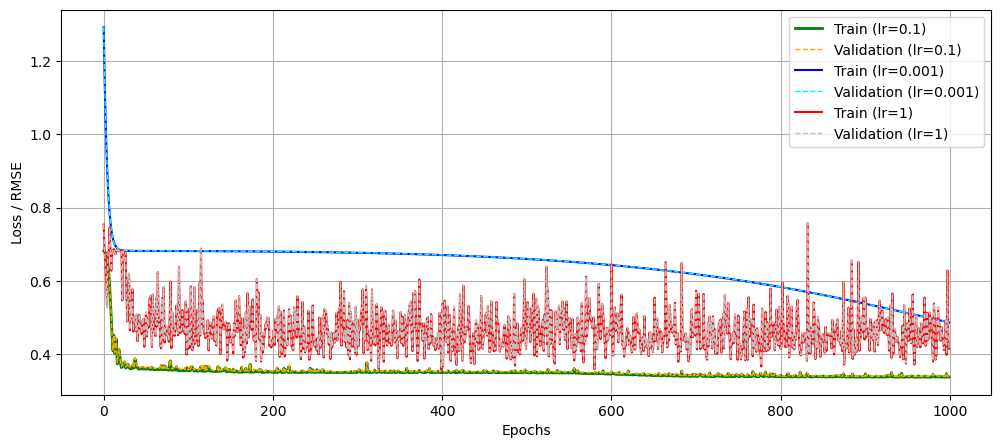

In [105]:
plt.figure(figsize=(12, 5))

# Define colors for each learning rate
colors_train = {0.001: 'blue', 0.1: 'green', 1: 'red'}
colors_valid = {0.001: 'cyan', 0.1: 'orange', 1: 'silver'}

# Plot loss history for each learning rate
for lr in [0.1, 0.001, 1]:
    plt.plot(results[lr]["train_loss"], label=f"Train (lr={lr})", color=colors_train[lr], lw=2. if lr == 0.1 else 1.5)
    plt.plot(results[lr]["val_rmse"], label=f"Validation (lr={lr})", color=colors_valid[lr], linestyle="--", lw=1. if lr == 0.1 else 1)

plt.xlabel("Epochs")
plt.ylabel("Loss / RMSE")
plt.legend()
plt.grid()
plt.show()

### <b>f. Train the model using mini-batch GD and features without log transforming</b>

In [18]:
# normalize
max_amp = np.max(data["X"][:, 0])
min_amp = np.min(data["X"][:, 0])
max_dist = np.max(data["X"][:, 1])
min_dist = np.min(data["X"][:, 1])
# rescale
norm_amp_noLog = (data["X"][:, 0] - min_amp) / (max_amp - min_amp)
norm_dist_noLog = (data["X"][:, 1] - min_dist) / (max_dist - min_dist)
# stack the data
X_noLog = np.column_stack((norm_amp_noLog, norm_dist_noLog))

# Split the dataset (use normalized log)
X_noLog_train, X_noLog_val, y_noLog_train, y_noLog_val = train_test_split(X_noLog, Ml, test_size=0.25, random_state=256)

print("Training set size:", X_noLog_train.shape[0])
print("Validation set size:", X_noLog_val.shape[0])

Training set size: 150000
Validation set size: 50000


In [22]:
results_noLog = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    params, train_loss_history, val_loss_history = Train_MiniBatch(
            X_noLog_train, y_noLog_train.reshape(-1, 1), X_noLog_val, y_noLog_val.reshape(-1,1),
            n_HiddenFeatures=n_HiddenFeatures, learning_rate=lr, epochs=1000, batch_size=1024
        )
    y_noLog_val_pred, _, _ = Forward(X_noLog_val, params)
    rmse = np.sqrt(mean_squared_error(y_noLog_val, y_noLog_val_pred))
    results_noLog[lr] = {"train_loss": train_loss_history, "val_rmse": val_loss_history}
    print(f"Validation RMSE for learning rate {lr}: {rmse}")


Training with learning rate: 0.001
shape of W1: (2, 32)
shape of W2: (32, 1)
shape of b1: (1, 32)
shape of b2: (1, 1)
Number of parameters in the neural network: 129
Epoch 100/1000, RMSE: 0.6821004180526111
Epoch 200/1000, RMSE: 0.6820278633421885
Epoch 300/1000, RMSE: 0.6819027670589574
Epoch 400/1000, RMSE: 0.6816808837682335
Epoch 500/1000, RMSE: 0.6812847274295976
Epoch 600/1000, RMSE: 0.6805788793605506
Epoch 700/1000, RMSE: 0.6793307226050401
Epoch 800/1000, RMSE: 0.67715515750185
Epoch 900/1000, RMSE: 0.6734572830629131
Epoch 1000/1000, RMSE: 0.667433361830781
Validation RMSE for learning rate 0.001: 0.6687377016289562
Training with learning rate: 0.1
shape of W1: (2, 32)
shape of W2: (32, 1)
shape of b1: (1, 32)
shape of b2: (1, 1)
Number of parameters in the neural network: 129
Epoch 100/1000, RMSE: 0.595267263529171
Epoch 200/1000, RMSE: 0.5937395374481791
Epoch 300/1000, RMSE: 0.5923683331862561
Epoch 400/1000, RMSE: 0.5924983026696828
Epoch 500/1000, RMSE: 0.592282003349137

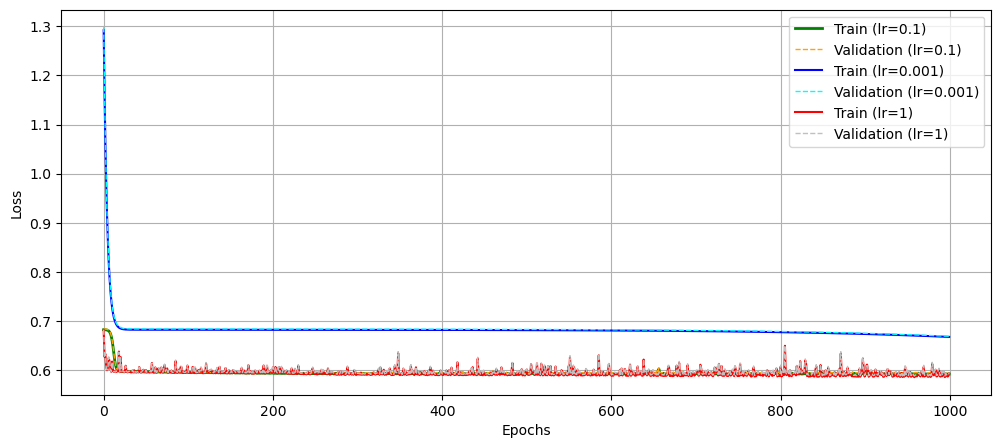

In [26]:
plt.figure(figsize=(12, 5))
# plt.yscale('log')

# Plot loss history for each learning rate
for lr in [0.1, 0.001, 1]:
    plt.plot(results_noLog[lr]["train_loss"], label=f"Train (lr={lr})", color=colors_train[lr], lw=2. if lr == 0.1 else 1.5)
    plt.plot(results_noLog[lr]["val_rmse"], label=f"Validation (lr={lr})", color=colors_valid[lr], linestyle="--", lw=1. if lr == 0.1 else 1)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

### <b>g. Train the model with all features</b>

In [115]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, Ml, test_size=0.25, random_state=128)

print("Training set size:", X1_train.shape[0])
print("Validation set size:", X1_val.shape[0])

# Split the dataset (use all features)
results_all_features = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    params_all_features, train_loss_all_features, val_loss_all_features = Train_MiniBatch(
        X1_train, y1_train.reshape(-1, 1), X1_val, y1_val.reshape(-1, 1),
        n_HiddenFeatures=nHiddenFeatures, learning_rate=lr, epochs=1000, batch_size=1024
    )
    y1_val_pred, _, _ = Forward(X1_val, params_all_features)
    rmse_all_features = np.sqrt(mean_squared_error(y1_val, y1_val_pred))
    results_all_features[lr] = {"train_loss": train_loss_all_features, "val_rmse": val_loss_all_features}
    print(f"Validation RMSE for learning rate {lr}: {rmse_all_features}")


Training set size: 150000
Validation set size: 50000
Training with learning rate: 0.001
shape of W1: (326, 32)
shape of W2: (32, 1)
shape of b1: (1, 32)
shape of b2: (1, 1)
Number of parameters in the neural network: 10497
Epoch 100/1000, RMSE: 0.6809573896259966
Epoch 200/1000, RMSE: 0.6772296362654704
Epoch 300/1000, RMSE: 0.6656217700320872
Epoch 400/1000, RMSE: 0.6373337128405652
Epoch 500/1000, RMSE: 0.5923380325287696
Epoch 600/1000, RMSE: 0.549296505191916
Epoch 700/1000, RMSE: 0.5135376394426432
Epoch 800/1000, RMSE: 0.48009890980392894
Epoch 900/1000, RMSE: 0.44782577463228973
Epoch 1000/1000, RMSE: 0.4175359032212446
Validation RMSE for learning rate 0.001: 0.41843002160965526
Training with learning rate: 0.1
shape of W1: (326, 32)
shape of W2: (32, 1)
shape of b1: (1, 32)
shape of b2: (1, 1)
Number of parameters in the neural network: 10497
Epoch 100/1000, RMSE: 0.2841232117702196
Epoch 200/1000, RMSE: 0.27885295442546193
Epoch 300/1000, RMSE: 0.27964813733275556
Epoch 400/1

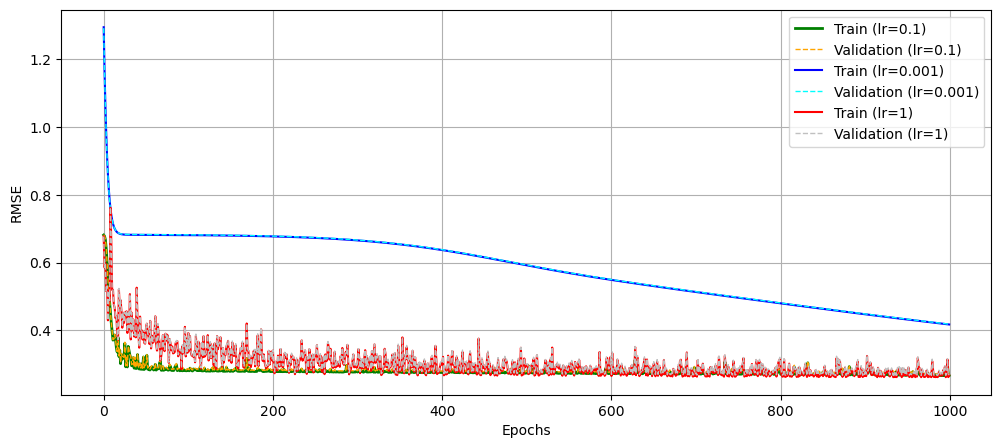

In [131]:
plt.figure(figsize=(12, 5))

# Define colors for each learning rate
colors_train = {0.001: 'blue', 0.1: 'green', 1: 'red'}
colors_valid = {0.001: 'cyan', 0.1: 'orange', 1: 'silver'}

# Plot loss history for each learning rate
for lr in [0.1, 0.001, 1]:
    plt.plot(results_all_features[lr]["train_loss"], label=f"Train (lr={lr})", color=colors_train[lr], lw=2. if lr == 0.1 else 1.5)
    plt.plot(results_all_features[lr]["val_rmse"], label=f"Validation (lr={lr})", color=colors_valid[lr], linestyle="--", lw=1. if lr == 0.1 else 1)

plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()